## 線形回帰

### 正規方程式

In [1]:
import numpy as np

X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

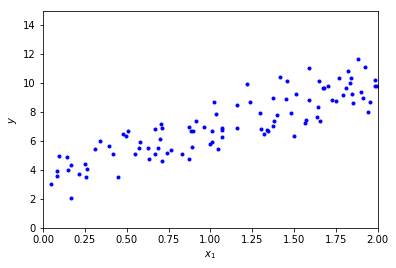

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.axis([0, 2, 0, 15])
plt.show()

In [3]:
X_b = np.c_[np.ones((100, 1)), X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [4]:
theta_best

array([[ 3.60844358],
       [ 3.21517098]])

In [5]:
# x1が0と2の時を予測してみる
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[  3.60844358],
       [ 10.03878554]])

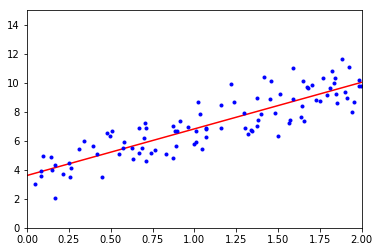

In [6]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show()

In [7]:
# scikit-learnを使った場合
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

/Users/uno/.pyenv/versions/3.6.1/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


(array([ 3.60844358]), array([[ 3.21517098]]))

In [8]:
lin_reg.predict(X_new)

array([[  3.60844358],
       [ 10.03878554]])

### 勾配降下法
- 線形回帰におけるMSEコスト関数は凸関数である
- 勾配降下方を使用するときはすべての特徴量のスケールが合うように指定すべき

#### 勾配降下法の種類は3つ
- バッチ勾配降下法　（全訓練データを用いるもの）
- 確率的勾配降下法　（訓練データからランダムで１つ選んでいく）
- ミニバッチ勾配降下法　（ランダムで選んだ小さい集合を用いる）

In [9]:
eta = 0.01 #学習率
n_iterations = 1000
m = 100
theta = np.random.randn(2,1)
theta_bgd = []

In [10]:
for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta*gradients
    if iteration%10 == 0:
#         print('theta:', theta[0], theta[1])
        theta_bgd.append([theta[0], theta[1]])

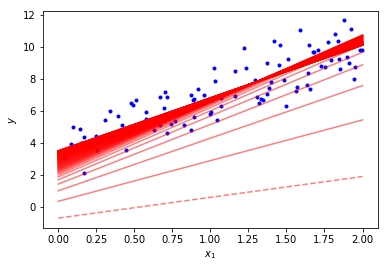

In [11]:
plt.plot(X, y, 'b.')
for i in range(len(theta_bgd)):
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2, 1)), X_new]
    y_predict = X_new_b.dot(theta_bgd[i])
    if i == 0:
        plt.plot(X_new, y_predict, 'r--', alpha=0.5)
    else:
        plt.plot(X_new, y_predict, 'r-', alpha=0.5)
plt.xlabel('$x_1$')
plt.ylabel('$y$')
plt.show()

### 確率的勾配降下法
- 上のバッチ勾配降下法では、勾配の計算で「すべての訓練セット」を使うため、計算速度が遅いことが問題
- 確率的勾配降下方法では、訓練セットからランダムで１つ選び勾配を計算することで高速化する
- 学習率は徐々に小さくしていく手法が一般的(焼きなまし方法)

In [12]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
    return t0/(t+t1) #学習が進みのつれ、徐々に学習率を小さくしていく

In [13]:
theta = np.random.randn(2, 1)
theta_sgd = [theta]
eta = 0.0001
for epoch in range(n_epochs):
    for i in range(m):  
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        if i == 0:
            theta_sgd.append([theta[0], theta[1]])

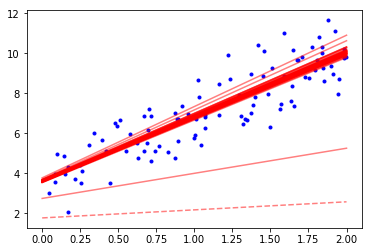

In [14]:
plt.plot(X, y, 'b.')
for i in range(len(theta_sgd)):
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2, 1)), X_new]
    y_predict = X_new_b.dot(theta_sgd[i])
    if i == 0:
        plt.plot(X_new, y_predict, 'r--', alpha=0.5)
    else:
        plt.plot(X_new, y_predict, 'r-', alpha=0.5)        
plt.show()

### ミニバッチ勾配降下法
- 訓練データからランダムで小さい集合を抽出して、それをつかう
- GPUアーキテクチャとの親和性が高く、パフォーマンスの向上が期待できる
- ミニバッチが大規模な場合にはSGDよりも最小値に近づきやすい
- 一方で、局所的な最小値に一度落ちると、抜けづらくなってします

In [15]:
minibatch_size = 20
theta = np.random.randn(2, 1)
theta_mgd = [theta]
eta = 0.0001

t0, t1 = 200, 1000
def learning_schedule(t):
    return t0 / (t + t1)

t = 0
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for i in range(0, m, minibatch_size):
        t += 1
        xi = X_b_shuffled[i:i+minibatch_size]
        yi = y_shuffled[i:i+minibatch_size]
        gradients = 2/minibatch_size * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(t)
        theta = theta - eta * gradients
        if i == 0:
            theta_mgd.append([theta[0], theta[1]])

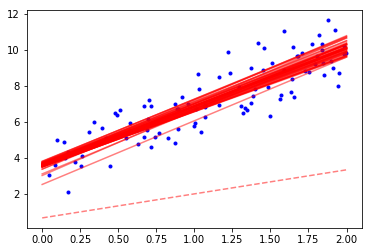

In [16]:
plt.plot(X, y, 'b.')
for i in range(len(theta_mgd)):
    X_new = np.array([[0],[2]])
    X_new_b = np.c_[np.ones((2, 1)), X_new]
    y_predict = X_new_b.dot(theta_mgd[i])
    if i == 0:
        plt.plot(X_new, y_predict, 'r--', alpha=0.5)
    else:
        plt.plot(X_new, y_predict, 'r-', alpha=0.5)        
plt.show()

#### バッチGD, SGD, ミニバッチGDの収束の様子

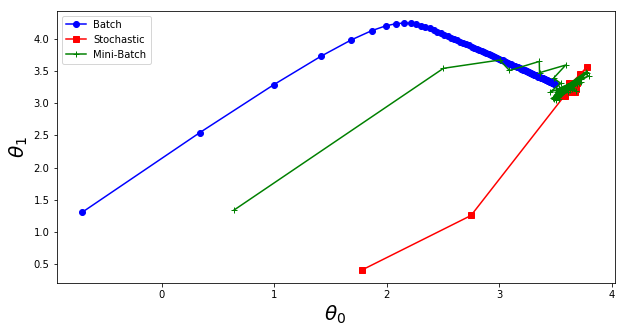

In [17]:
plt.figure(figsize=(10,5))
plt.plot(np.array(theta_bgd)[:, 0], np.array(theta_bgd)[:, 1], 'b-o', label='Batch')
plt.plot(np.array(theta_sgd)[:, 0], np.array(theta_sgd)[:, 1], 'r-s', label='Stochastic')
plt.plot(np.array(theta_mgd)[:, 0], np.array(theta_mgd)[:, 1], 'g-+', label='Mini-Batch')
plt.legend()
plt.xlabel(r"$\theta_0$", fontsize=20)
plt.ylabel(r"$\theta_1$", fontsize=20)
plt.show()

### 多項式回帰

In [18]:
import numpy as np
import numpy.random as rnd
np.random.seed(42)

In [19]:
m = 100
X = 6*np.random.rand(m, 1)-3
y = 0.5*X**2 + X + 2 + np.random.randn(m, 1)

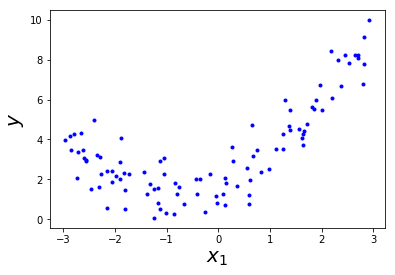

In [20]:
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$y$', fontsize=20)
plt.show()

In [21]:
# sklearnによる重回帰
# XをX**2に変換して新たな特徴量を作る
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) # degreeは次数（ここでは２次多項式）
X_poly = poly_features.fit_transform(X)

In [22]:
# 新たな特徴量X_polyで学習する
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([ 1.78134581]), array([[ 0.93366893,  0.56456263]]))

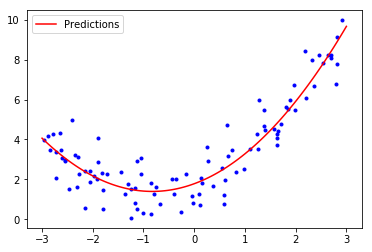

In [23]:
X_new=np.linspace(-3,3,100).reshape(100,1)
X_new_poly=poly_features.transform(X_new)
y_new=lin_reg.predict(X_new_poly)
plt.plot(X,y,'b.')
plt.plot(X_new,y_new,'r-', label='Predictions')
plt.legend()
plt.show()

### 学習曲線
- 上記では２次多項式だったが、関数によっては何次がよいのかわからない
- 次数を探索するため、過学習を観察する学習曲線が必要である

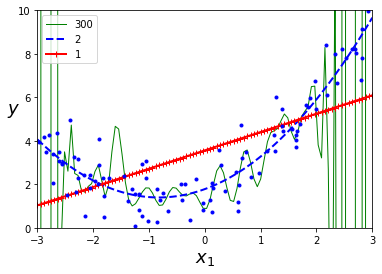

In [24]:
# さきほどのモデルを2次よりも大きい多項式でやってみる（1次、2次、300次）
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 300), ("b--", 2, 2), ("r-+", 2, 1)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-3, 3, 0, 10])
plt.show()

# 緑の300次元はとても過学習していることがわかる

In [25]:
from  sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

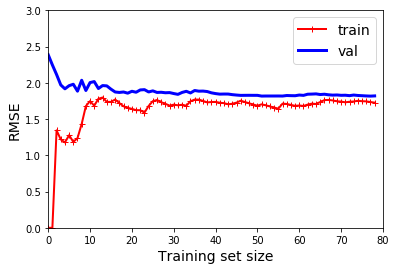

In [26]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

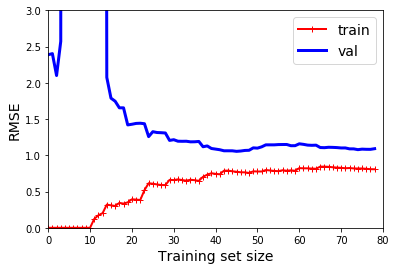

In [27]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

### 正則化
- モデルの過学習を防ぐための手法
- 正則化の例）リッジ回帰、Lasso回帰、ElasticNet

In [28]:
# リッジ回帰（コスト関数に正則化項を加えたもので、ハイパーパラメータが大きいほどすべての重みが限りになく０に近くため、水平に近く）
# 重みベクトルのl2ノルムを使用
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3*np.random.rand(m, 1)
y = 1 + 0.5 *X + np.random.randn(m,1)/1.5

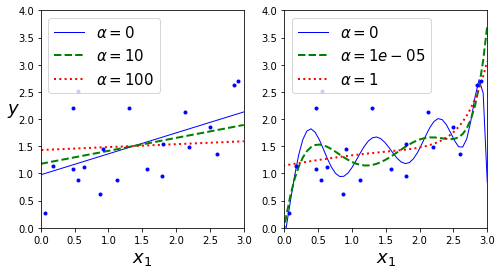

In [29]:
def plot_model(model_class, polynomial, alphas, **model_kargs):
    for alpha, style in zip(alphas, ("b-", "g--", "r:")):
        model = model_class(alpha, **model_kargs) if alpha > 0 else LinearRegression()
        if polynomial:
            model = Pipeline([
                    ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                    ("std_scaler", StandardScaler()),
                    ("regul_reg", model),
                ])
        model.fit(X, y)
        y_new_regul = model.predict(X_new)
        lw = 2 if alpha > 0 else 1
        plt.plot(X_new, y_new_regul, style, linewidth=lw, label=r"$\alpha = {}$".format(alpha))
    plt.plot(X, y, "b.", linewidth=3)
    plt.legend(loc="upper left", fontsize=15)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 3, 0, 4])

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)

plt.show()

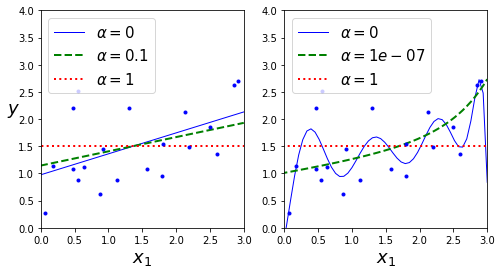

In [30]:
# Lasso回帰
# 重みベクトルのl1ノルムを使用
# 重要性の低い特徴量の重みを完全に取り除いてしまうという特徴がある
from sklearn.linear_model import Lasso

plt.figure(figsize=(8,4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 10**-7, 1), tol=1, random_state=42)

plt.show()

In [31]:
# Elastic Net
# リッジ回帰とLasso回帰の中間に位置付けられるものであり、リッジ回帰とLasso回帰を割合rで混ぜたもの
# r=0のときはリッジ回帰に等しく、r=1のときはLasso回帰に等しい
from sklearn.linear_model import ElasticNet
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([ 1.54333232])

### 学習の早期打ち切り

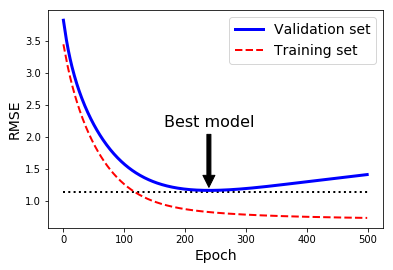

In [33]:
from sklearn.linear_model import SGDRegressor
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=90, include_bias=False)),
        ("std_scaler", StandardScaler()),
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       penalty=None,
                       eta0=0.0005,
                       warm_start=True,
                       learning_rate="constant",
                       random_state=42)

n_epochs = 500
train_errors, val_errors = [], []
for epoch in range(n_epochs):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_train_predict = sgd_reg.predict(X_train_poly_scaled)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    train_errors.append(mean_squared_error(y_train, y_train_predict))
    val_errors.append(mean_squared_error(y_val, y_val_predict))

best_epoch = np.argmin(val_errors)
best_val_rmse = np.sqrt(val_errors[best_epoch])

plt.annotate('Best model',
             xy=(best_epoch, best_val_rmse),
             xytext=(best_epoch, best_val_rmse + 1),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.05),
             fontsize=16,
            )

best_val_rmse -= 0.03  # just to make the graph look better
plt.plot([0, n_epochs], [best_val_rmse, best_val_rmse], "k:", linewidth=2)
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="Validation set")
plt.plot(np.sqrt(train_errors), "r--", linewidth=2, label="Training set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("RMSE", fontsize=14)
plt.show()

### ロジスティック回帰
- インスタンスが特定のクラスに属する確率を推計する

In [34]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names']

In [35]:
print(iris.DESCR)

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20  0.76     0.9565  (high!)
    ============== ==== ==== ======= ===== ====================

    :Missing Attribute Values: None
  

In [36]:
X = iris["data"][:,3:]
y = (iris["target"] == 2).astype(np.int)

In [37]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)

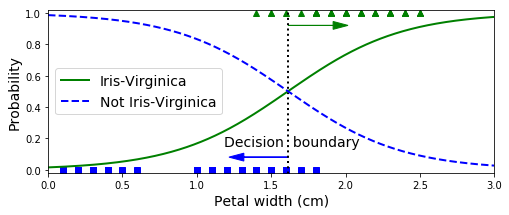

In [39]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris-Virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris-Virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary, 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary, 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

### ソフトマックス回帰（多項ロジスティック回帰）
- 多種類のクラスの確率を推計する（上記の多クラス版）
- １つのインスタンスが入力されると、ここのクラスの確率を推計する
- すべてのスコアの指数を計算してから、結果を正規化する

In [40]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

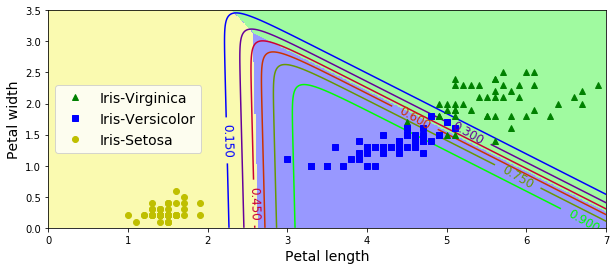

In [42]:
x0,x1 =  np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris-Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris-Versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris-Setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()